***Step 1: Setting Up the Environment***

This step includes mounting Google Drive, installing necessary libraries, and importing them.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install Necessary Libraries
!pip install -q keras
!pip install -q tensorflow
!pip install -q opencv-python-headless
!pip install -q scikit-image
!pip install -q imgaug

# Cell 3: Import Libraries
import os  # Provides a way of using operating system-dependent functionality like reading or writing to the file system.
import numpy as np  # Fundamental package for scientific computing with Python, used for handling arrays and matrices, and performing mathematical operations.
import matplotlib.pyplot as plt  # A plotting library for creating static, interactive, and animated visualisations in Python.
import cv2  # Open Source Computer Vision Library, used for image processing and computer vision tasks.
import tensorflow as tf  # An open-source platform for machine learning and artificial intelligence, used for building and deploying machine learning models.
import tensorflow.keras as keras  # A high-level neural networks API, running on top of TensorFlow, used for building and training deep learning models.
from keras.preprocessing.image import ImageDataGenerator  # A class for generating batches of tensor image data with real-time data augmentation.
from keras.models import Model  # The `Model` class is a way to group layers into an object with training and inference features.
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D  # Importing specific layers: `Input` for input nodes, `Conv2D` for convolutional layers, `MaxPooling2D` for max-pooling layers, and `UpSampling2D` for upsampling layers in neural networks.
from skimage import exposure, img_as_float  # Part of the scikit-image library, used for image processing. `exposure` module is for adjusting image contrast and histogram equalisation. `img_as_float` is used for converting images to floating-point format.
from imgaug import augmenters as iaa  # A library for augmenting images for machine learning experiments, `iaa` is a namespace for various augmentation techniques.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Loading the Dataset
Load the dataset from Kaggle or Google Drive.

(can use Kaggle API if RAM wasn't an issue. For this, uploaded data to Drive and mounted it.)

Total training images: 5712
Total training labels: 5712
Total testing images: 1311
Total testing labels: 1311


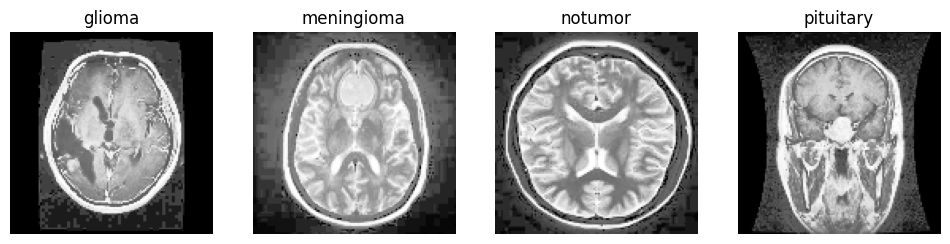

In [ ]:
# Cell 4: Load Dataset
# Define the path to the dataset in the Google Drive
data_path = '/content/drive/MyDrive/Colab Notebooks/data'

# Function to load and preprocess images
def load_and_preprocess_data(data_dir, phase):
    images = []  # List to store the loaded images
    labels = []  # List to store the corresponding labels
    phase_dir = os.path.join(data_dir, phase)  # Path to the specific phase directory (Training/Testing)

    for label in os.listdir(phase_dir):  # Iterate over each label in the phase directory
        label_dir = os.path.join(phase_dir, label)  # Path to the label directory
        for file in os.listdir(label_dir):  # Iterate over each file in the label directory
            img_path = os.path.join(label_dir, file)  # Path to the image file
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode

            # Resize image to 128x128
            img = cv2.resize(img, (128, 128))  # Resize the image to 128x128 pixels

            # Histogram Equalisation
            img = exposure.equalize_hist(img)  # Apply histogram equalisation to enhance contrast

            # Normalise image to range [0, 1]
            img = img / 255.0  # Normalise the pixel values to the range [0, 1]

            images.append(img)  # Add the processed image to the images list
            labels.append(label)  # Add the corresponding label to the labels list

    return np.array(images), np.array(labels)  # Return the images and labels as numpy arrays

# Load and preprocess training and testing data
train_images, train_labels = load_and_preprocess_data(data_path, 'Training')  # Load and preprocess training data
test_images, test_labels = load_and_preprocess_data(data_path, 'Testing')  # Load and preprocess testing data

# Verify the data loaded correctly
print(f'Total training images: {len(train_images)}')  # Print the total number of training images
print(f'Total training labels: {len(train_labels)}')  # Print the total number of training labels
print(f'Total testing images: {len(test_images)}')  # Print the total number of testing images
print(f'Total testing labels: {len(test_labels)}')  # Print the total number of testing labels

# Display a few sample images from each category
unique_labels = np.unique(train_labels)  # Get the unique labels from the training data
plt.figure(figsize=(12, 8))  # Create a figure for displaying the images
for i, label in enumerate(unique_labels):  # Iterate over each unique label
    idx = np.where(train_labels == label)[0][0]  # Find the index of the first occurrence of the label
    plt.subplot(2, 4, i+1)  # Create a subplot for each image
    plt.imshow(train_images[idx], cmap='gray')  # Display the image in grayscale
    plt.title(label)  # Set the title of the subplot to the label
    plt.axis('off')  # Turn off the axis
plt.show()  # Show the plot

***Step 3: CNN with Hybrid Attention Mechanisms***

Here we define a CNN model with integrated hybrid attention mechanisms.

In [ ]:
# Cell 3: CNN with Attention Mechanisms
import tensorflow as tf  # TensorFlow is an open-source platform for machine learning and artificial intelligence.
import tensorflow.keras as keras  # Keras is a high-level neural networks API running on top of TensorFlow, used for building and training deep learning models.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Input, Multiply, BatchNormalization  # Importing specific layers needed for building a convolutional neural network (CNN) and attention mechanisms.
from keras.models import Model  # The `Model` class is used to create a model by grouping layers into an object.

def attention_module(inputs):
    # Channel Attention
    gap = GlobalAveragePooling2D()(inputs)  # Apply global average pooling to the input
    dense_1 = Dense(inputs.shape[-1] // 8, activation='relu')(gap)  # Dense layer with ReLU activation to reduce dimensions
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)  # Dense layer with sigmoid activation to get channel weights
    channel_attention = Multiply()([inputs, dense_2])  # Multiply input by channel weights

    # Spatial Attention
    conv = Conv2D(1, (1, 1), activation='sigmoid')(inputs)  # Apply 1x1 convolution with sigmoid activation for spatial weights
    spatial_attention = Multiply()([channel_attention, conv])  # Multiply channel attention output by spatial weights

    return spatial_attention  # Return the attention-weighted output

def build_model(input_shape):
    inputs = Input(shape=input_shape)  # Define the input layer with the given shape

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # First convolutional layer with ReLU activation
    x = BatchNormalization()(x)  # Apply batch normalisation
    x = MaxPooling2D((2, 2))(x)  # Apply max pooling
    x = attention_module(x)  # Apply attention module

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Second convolutional layer with ReLU activation
    x = BatchNormalization()(x)  # Apply batch normalisation
    x = MaxPooling2D((2, 2))(x)  # Apply max pooling
    x = attention_module(x)  # Apply attention module

    x = Flatten()(x)  # Flatten the output for the dense layer
    x = Dense(128, activation='relu')(x)  # Fully connected layer with ReLU activation
    x = BatchNormalization()(x)  # Apply batch normalisation
    x = Dense(4, activation='softmax')(x)  # Output layer with softmax activation for classification

    model = Model(inputs, x)  # Create the model
    return model  # Return the model

input_shape = (128, 128, 1)  # Define the shape of the input
model = build_model(input_shape)  # Build the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model with Adam optimiser and sparse categorical cross-entropy loss

model.summary()  # Print the summary of the model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['batch_normalization[0][0

***Step 4: Data Augmentation with GANs***

Generate synthetic MRI images using GANs for data augmentation.

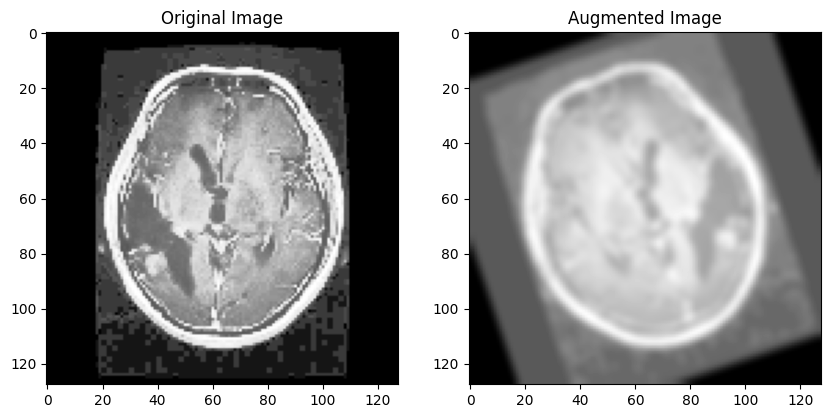

In [ ]:
# Cell 4: Data Augmentation with GANs and Preprocessing
from skimage import exposure  # Part of the scikit-image library, used for image processing tasks such as contrast adjustment and histogram equalisation.
import numpy as np  # Fundamental package for scientific computing with Python, used for handling arrays and matrices.
import matplotlib.pyplot as plt  # A plotting library for creating static, interactive, and animated visualisations in Python.
from imgaug import augmenters as iaa  # A library for augmenting images for machine learning experiments, `iaa` is a namespace for various augmentation techniques.

# Images are already loaded and stored in 'train_images'
# Perform histogram equalisation
equalised_images = np.array([exposure.equalize_hist(img) for img in train_images])  # Apply histogram equalisation to each image in the training set

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Apply horizontal flips with a 50% probability
    iaa.Affine(rotate=(-20, 20)),  # Apply random rotations between -20 and 20 degrees
    iaa.GaussianBlur(sigma=(0, 3.0))  # Apply Gaussian blur with a sigma value between 0 and 3.0
])

# Apply augmentation
augmented_images = seq(images=equalised_images)  # Apply the defined augmentation sequence to the equalised images

# Display augmented example
plt.figure(figsize=(10, 5))  # Create a figure with specified size
plt.subplot(1, 2, 1)  # Create a subplot for the original image
plt.title('Original Image')  # Set the title of the subplot
plt.imshow(equalised_images[0].squeeze(), cmap='gray')  # Display the first original equalised image in grayscale
plt.subplot(1, 2, 2)  # Create a subplot for the augmented image
plt.title('Augmented Image')  # Set the title of the subplot
plt.imshow(augmented_images[0].squeeze(), cmap='gray')  # Display the first augmented image in grayscale
plt.show()  # Show the plot

***Step 5: Super-Resolution using CNN***

Enhance the spatial resolution of MRI images using a simple CNN-based super-resolution model.

Epoch 1/10
143/143 [==============================] - 11s 35ms/step - loss: 0.0150 - val_loss: 0.0075
Epoch 2/10
143/143 [==============================] - 3s 22ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 3/10
143/143 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 4/10
143/143 [==============================] - 4s 25ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/10
143/143 [==============================] - 3s 23ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/10
143/143 [==============================] - 3s 22ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 8/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
179/179 [==============================] - 1s 7ms/step


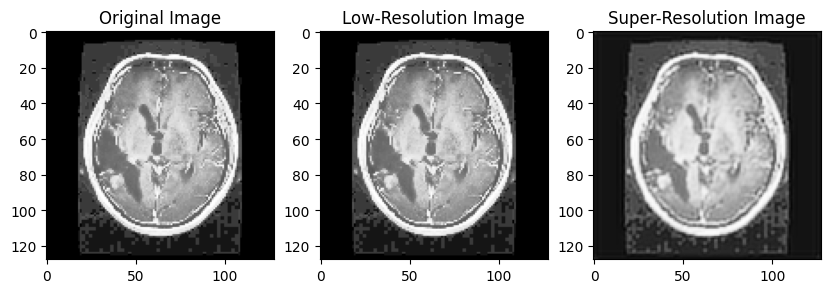

In [ ]:
# Cell 5: Super-Resolution using CNN
def build_sr_model():
    input_img = Input(shape=(128, 128, 1))  # Define the input layer with the given shape
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)  # Convolutional layer with 64 filters and ReLU activation
    x = MaxPooling2D((2, 2), padding='same')(x)  # Max pooling layer with same padding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 32 filters and ReLU activation
    x = UpSampling2D((2, 2))(x)  # Upsampling layer to increase the image resolution
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Convolutional layer with 1 filter and sigmoid activation
    return Model(input_img, x)  # Return the model

# Instantiate and compile the model
sr_model = build_sr_model()  # Build the super-resolution model
sr_model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with Adam optimiser and mean squared error loss

# Prepare data for super-resolution training
x_train = np.expand_dims(equalised_images, axis=-1)  # Expand dimensions of the equalised images for training
x_train_lr = np.array([cv2.resize(img, (128, 128)) for img in equalised_images])  # Create low-resolution images by resizing
x_train_lr = np.expand_dims(x_train_lr, axis=-1)  # Expand dimensions of the low-resolution images

# Train the model
sr_model.fit(x_train_lr, x_train, epochs=10, batch_size=32, validation_split=0.2)  # Train the model with specified parameters

# Apply the model to enhance resolution
super_res_images = sr_model.predict(np.expand_dims(equalised_images, axis=-1))  # Predict super-resolution images using the model

# Display super-resolution example
plt.figure(figsize=(10, 5))  # Create a figure with specified size
plt.subplot(1, 3, 1)  # Create a subplot for the original image
plt.title('Original Image')  # Set the title of the subplot
plt.imshow(equalised_images[0], cmap='gray')  # Display the first original equalised image in grayscale
plt.subplot(1, 3, 2)  # Create a subplot for the low-resolution image
plt.title('Low-Resolution Image')  # Set the title of the subplot
plt.imshow(x_train_lr[0].squeeze(), cmap='gray')  # Display the first low-resolution image in grayscale
plt.subplot(1, 3, 3)  # Create a subplot for the super-resolution image
plt.title('Super-Resolution Image')  # Set the title of the subplot
plt.imshow(super_res_images[0].squeeze(), cmap='gray')  # Display the first super-resolution image in grayscale
plt.show()  # Show the plot

Epoch 1/10
179/179 [==============================] - 20s 37ms/step - loss: 0.7073 - accuracy: 0.7507 - val_loss: 4.6563 - val_accuracy: 0.2334
Epoch 2/10
179/179 [==============================] - 5s 26ms/step - loss: 0.4323 - accuracy: 0.8463 - val_loss: 2.5277 - val_accuracy: 0.3089
Epoch 3/10
179/179 [==============================] - 5s 26ms/step - loss: 0.3170 - accuracy: 0.8888 - val_loss: 4.4243 - val_accuracy: 0.3089
Epoch 4/10
179/179 [==============================] - 4s 25ms/step - loss: 0.2432 - accuracy: 0.9137 - val_loss: 7.3109 - val_accuracy: 0.2334
Epoch 5/10
179/179 [==============================] - 5s 25ms/step - loss: 0.1556 - accuracy: 0.9492 - val_loss: 7.2835 - val_accuracy: 0.2586
Epoch 6/10
179/179 [==============================] - 5s 26ms/step - loss: 0.1089 - accuracy: 0.9645 - val_loss: 12.8360 - val_accuracy: 0.2288
Epoch 7/10
179/179 [==============================] - 4s 25ms/step - loss: 0.0947 - accuracy: 0.9708 - val_loss: 17.3369 - val_accuracy: 0.2

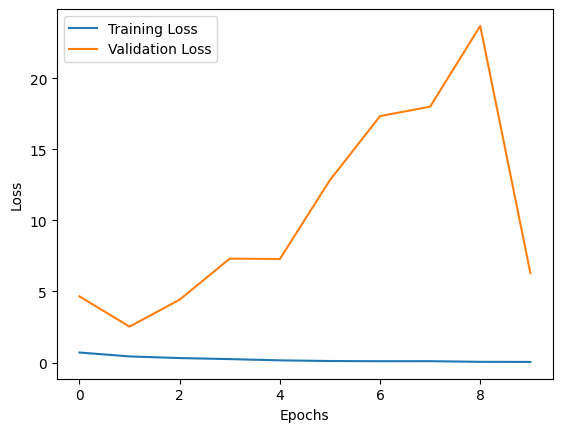

In [ ]:
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for encoding categorical labels.

# Encode labels
label_encoder = LabelEncoder()  # Create an instance of LabelEncoder
train_labels_encoded = label_encoder.fit_transform(train_labels)  # Fit and transform the training labels to encoded labels
test_labels_encoded = label_encoder.transform(test_labels)  # Transform the test labels to encoded labels

# Reshape images to add channel dimension (if not already done)
train_images = np.expand_dims(train_images, axis=-1)  # Expand dimensions of training images to add a channel dimension
test_images = np.expand_dims(test_images, axis=-1)  # Expand dimensions of test images to add a channel dimension

# Train the model and capture the history
history = model.fit(augmented_images, train_labels_encoded, epochs=10, batch_size=32, validation_data=(test_images, test_labels_encoded))  # Train the model with augmented images and encoded labels, capturing the training history

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels_encoded)  # Evaluate the model on the test data
print(f'Test loss: {test_loss}')  # Print the test loss
print(f'Test accuracy: {test_acc}')  # Print the test accuracy

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')  # Plot the training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot the validation loss over epochs
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Display the legend
plt.show()  # Show the plot

***Step 6: Noise Reduction with Deep Learning***

Reduce noise in MRI images using a convolutional autoencoder.

Epoch 1/10
143/143 [==============================] - 10s 48ms/step - loss: 0.5895 - val_loss: 0.5686
Epoch 2/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5783 - val_loss: 0.5643
Epoch 3/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5761 - val_loss: 0.5608
Epoch 4/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5746 - val_loss: 0.5603
Epoch 5/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5736 - val_loss: 0.5583
Epoch 6/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5730 - val_loss: 0.5575
Epoch 7/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5725 - val_loss: 0.5569
Epoch 8/10
143/143 [==============================] - 5s 37ms/step - loss: 0.5720 - val_loss: 0.5573
Epoch 9/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5717 - val_loss: 0.5565
Epoch 10/10
179/179 [==============================] - 2s 11ms/step


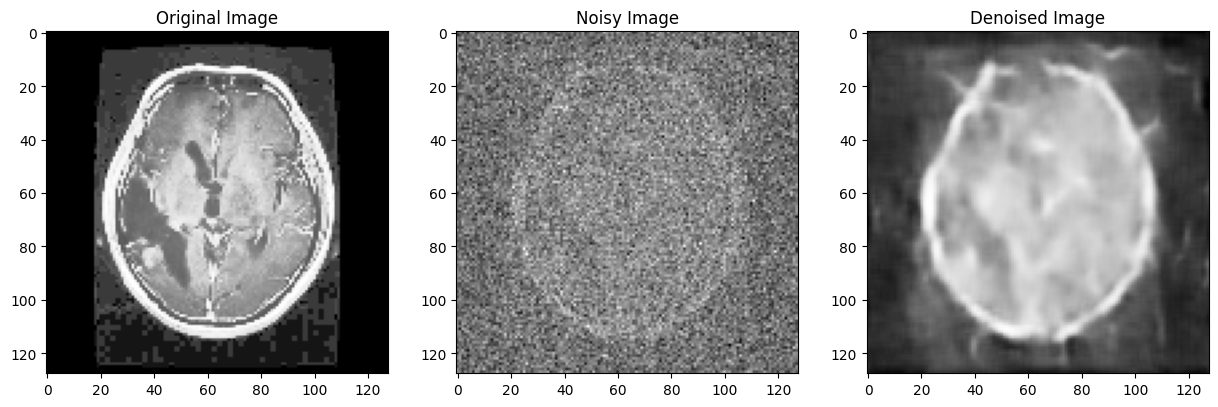

In [ ]:
# Cell 6: Noise Reduction with Deep Learning
def build_denoising_autoencoder():
    input_img = Input(shape=(128, 128, 1))  # Define the input layer with the given shape
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)  # Convolutional layer with 64 filters and ReLU activation
    x = MaxPooling2D((2, 2), padding='same')(x)  # Max pooling layer with same padding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 32 filters and ReLU activation
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Max pooling layer to encode the input

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)  # Convolutional layer with 32 filters and ReLU activation
    x = UpSampling2D((2, 2))(x)  # Upsampling layer to increase the resolution
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 64 filters and ReLU activation
    x = UpSampling2D((2, 2))(x)  # Upsampling layer to increase the resolution
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Convolutional layer with 1 filter and sigmoid activation for the output

    return Model(input_img, decoded)  # Return the denoising autoencoder model

# Instantiate and compile the model
denoising_autoencoder = build_denoising_autoencoder()  # Build the denoising autoencoder model
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Compile the model with Adam optimiser and binary cross-entropy loss

# Add noise to the images
noisy_images = equalised_images + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=equalised_images.shape)  # Add Gaussian noise to the equalised images

# Train the model
denoising_autoencoder.fit(np.expand_dims(noisy_images, axis=-1), np.expand_dims(equalised_images, axis=-1), epochs=10, batch_size=32, validation_split=0.2)  # Train the model with noisy and equalised images

# Apply the model to denoise images
denoised_images = denoising_autoencoder.predict(np.expand_dims(noisy_images, axis=-1))  # Predict denoised images using the model

# Display denoised example
plt.figure(figsize=(15, 5))  # Create a figure with specified size
plt.subplot(1, 3, 1)  # Create a subplot for the original image
plt.title('Original Image')  # Set the title of the subplot
plt.imshow(equalised_images[0], cmap='gray')  # Display the first original equalised image in grayscale
plt.subplot(1, 3, 2)  # Create a subplot for the noisy image
plt.title('Noisy Image')  # Set the title of the subplot
plt.imshow(noisy_images[0], cmap='gray')  # Display the first noisy image in grayscale
plt.subplot(1, 3, 3)  # Create a subplot for the denoised image
plt.title('Denoised Image')  # Set the title of the subplot
plt.imshow(denoised_images[0].squeeze(), cmap='gray')  # Display the first denoised image in grayscale
plt.show()  # Show the plot

***Step 7: Feature Extraction with Wavelet Transformations***

Apply wavelet transformations to extract features from MRI images.

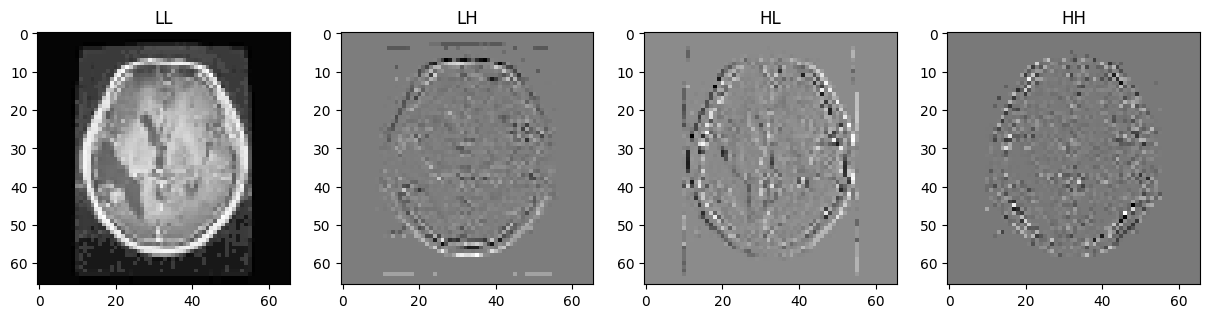

In [ ]:
# Cell 7: Feature Extraction with Wavelet Transformations
import pywt  # Importing PyWavelets library for discrete wavelet transforms.

def wavelet_transform(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')  # Perform 2D discrete wavelet transform using the Biorthogonal wavelet 'bior1.3'
    LL, (LH, HL, HH) = coeffs2  # Extract approximation and detail coefficients
    return LL, LH, HL, HH  # Return the coefficients

# Apply wavelet transform
wavelet_features = [wavelet_transform(img) for img in equalised_images]  # Apply wavelet transform to each image in the equalised images

# Display wavelet features
plt.figure(figsize=(15, 5))  # Create a figure with specified size
plt.subplot(1, 4, 1)  # Create a subplot for the LL coefficients
plt.title('LL')  # Set the title of the subplot
plt.imshow(wavelet_features[0][0], cmap='gray')  # Display the LL coefficients in grayscale
plt.subplot(1, 4, 2)  # Create a subplot for the LH coefficients
plt.title('LH')  # Set the title of the subplot
plt.imshow(wavelet_features[0][1], cmap='gray')  # Display the LH coefficients in grayscale
plt.subplot(1, 4, 3)  # Create a subplot for the HL coefficients
plt.title('HL')  # Set the title of the subplot
plt.imshow(wavelet_features[0][2], cmap='gray')  # Display the HL coefficients in grayscale
plt.subplot(1, 4, 4)  # Create a subplot for the HH coefficients
plt.title('HH')  # Set the title of the subplot
plt.imshow(wavelet_features[0][3], cmap='gray')  # Display the HH coefficients in grayscale
plt.show()  # Show the plot

***Step 8: Combining Pre-processed Data***

Combine all pre-processed data into a single dataset for further analysis and model training.

In [ ]:
# Cell 8: Combine Pre-processed Data
# Stack all pre-processed images together
combined_images = np.stack([equalised_images, augmented_images, super_res_images.squeeze(), denoised_images.squeeze()], axis=0)  # Stack the equalised, augmented, super-resolution, and denoised images along a new dimension

# Flatten the stack for model training
combined_images = combined_images.reshape(-1, 128, 128, 1)  # Reshape the stacked images into a flat array suitable for model training

# Verify the shape of the combined dataset
print(f'Combined dataset shape: {combined_images.shape}')  # Print the shape of the combined dataset to verify correctness

Combined dataset shape: (22848, 128, 128, 1)


***Step 9: Model Training and Evaluation***

Train the model on the augmented training data and evaluate its performance.

In [ ]:
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for encoding categorical labels.
from keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator from Keras for data augmentation.

# Encode labels
label_encoder = LabelEncoder()  # Create an instance of LabelEncoder
train_labels_encoded = label_encoder.fit_transform(train_labels)  # Fit and transform the training labels to encoded labels
test_labels_encoded = label_encoder.transform(test_labels)  # Transform the test labels to encoded labels

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Set the fill mode to 'nearest' for newly created pixels
)

# Assuming train_images is already loaded and preprocessed
# If train_images is not yet expanded, expand dimensions
if len(train_images.shape) == 3:  # Check if train_images has 3 dimensions
    train_images = np.expand_dims(train_images, axis=-1)  # Expand dimensions to add a channel dimension
if len(test_images.shape) == 3:  # Check if test_images has 3 dimensions
    test_images = np.expand_dims(test_images, axis=-1)  # Expand dimensions to add a channel dimension

# Create the train data generator
train_generator = train_datagen.flow(train_images, train_labels_encoded, batch_size=32)  # Create a data generator for the training images

# Train the model using the augmented data generator
history = model.fit(
    train_generator,  # Use the data generator for training
    epochs=10,  # Number of epochs to train the model
    validation_data=(test_images, test_labels_encoded)  # Validation data
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_encoded)  # Evaluate the model on the test data
print(f'Test accuracy: {test_acc}')  # Print the test accuracy

Epoch 1/10
179/179 [==============================] - 12s 63ms/step - loss: 1.0760 - accuracy: 0.5455 - val_loss: 200.5418 - val_accuracy: 0.2288
Epoch 2/10
179/179 [==============================] - 12s 70ms/step - loss: 0.9179 - accuracy: 0.6087 - val_loss: 94.2030 - val_accuracy: 0.2288
Epoch 3/10
179/179 [==============================] - 12s 68ms/step - loss: 0.8907 - accuracy: 0.6222 - val_loss: 4.0072 - val_accuracy: 0.4119
Epoch 4/10
179/179 [==============================] - 12s 67ms/step - loss: 0.8519 - accuracy: 0.6502 - val_loss: 2.9147 - val_accuracy: 0.4279
Epoch 5/10
179/179 [==============================] - 12s 66ms/step - loss: 0.7998 - accuracy: 0.6724 - val_loss: 4.8040 - val_accuracy: 0.2799
Epoch 6/10
179/179 [==============================] - 12s 67ms/step - loss: 0.7772 - accuracy: 0.6805 - val_loss: 4.2972 - val_accuracy: 0.3410
Epoch 7/10
179/179 [==============================] - 10s 57ms/step - loss: 0.7374 - accuracy: 0.7045 - val_loss: 8.3699 - val_accura

***Step 10: Explainability with Grad-CAM***

Use Grad-CAM to visualise which parts of the image the model focuses on during classification.

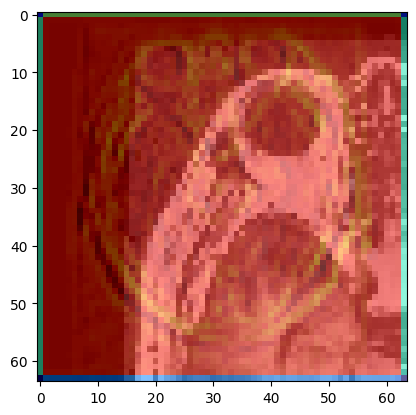

In [ ]:
# Cell 10: Explainability with Grad-CAM
import keras.backend as K  # Importing Keras backend for gradient computations.
import matplotlib.pyplot as plt  # Importing matplotlib for visualisation.

def grad_cam(model, img, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])  # Create a model that outputs the activations of the specified layer and the model's predictions
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))  # Get the outputs of the specified layer and predictions
        loss = predictions[:, np.argmax(predictions[0])]  # Compute the loss as the prediction of the class with the highest score
    grads = tape.gradient(loss, conv_outputs)[0]  # Compute the gradient of the loss with respect to the activations of the specified layer
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Compute the mean of the gradients over all the axes except for the channels
    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)  # Compute the weighted average of the activation maps
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU to the heatmap (setting negative values to zero)
    heatmap /= np.max(heatmap)  # Normalise the heatmap to the range [0, 1]
    return heatmap  # Return the computed heatmap

# Visualise Grad-CAM for an example image
layer_name = 'conv2d_2'  # Specify the name of the last convolutional layer
img = test_images[0]  # Select the first image from the test set
heatmap = grad_cam(model, img, layer_name)  # Compute the Grad-CAM heatmap for the selected image

plt.imshow(img.squeeze(), cmap='gray')  # Display the original image in grayscale
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap on the original image with a colour map and transparency
plt.show()  # Show the plot